$$\Large\text{Day 12: Flower Classification with Transfer Learning and DenseNet}$$


In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix


In [2]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 100
BATCH_SIZE = 4
ES_PATIENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 7
IMG_HEIGHT= 200
IMG_WIDTH= 200
FLIP_MODE = 'horizontal_and_vertical'
FILL_MODE = 'nearest'
ROTATION_FACTOR = (-0.1,0.1)
# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 
subDir = 'flower_photos'
altName = 'densenet_model'

###----------------------
### Some basic parameters
###----------------------

# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [3]:
'''
    For reading from web link
'''
#import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file(origin=dataset_url,
#                                   fname='flower_photos',
#                                   untar=True)
#data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
data_dir = os.path.join(inpDir, subDir)

In [4]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset="training",
    seed=RANDOM_STATE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    subset="validation",
    seed=RANDOM_STATE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=TEST_SIZE,
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

display(class_names, num_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

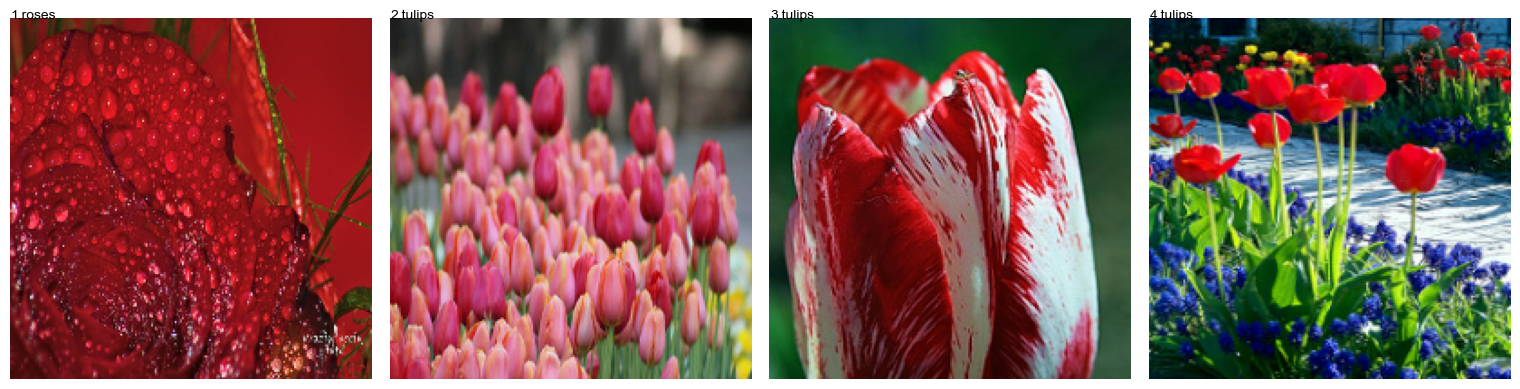

In [7]:
#create a new figure for the grid of images with a specified size
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0
#  Take 1 Batch
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//4, 4, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.text(
            x=0,
            y=0,
            s=f'{i+1}.{class_names[labels[i].numpy()]}', 
            color='black', 
            fontsize=10
        )
        plt.axis('off')
        
    plt.show()
    i += 1

plt.show()  


In [8]:
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0
#  Take 1 Batch
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE//8, 8, i+1)
        plt.grid(False)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.text(
            x=0,
            y=0,
            s=f'{i+1}.{class_names[labels[i].numpy()]}', 
            color='black', 
            fontsize=10
        )
        plt.axis('off')
        
    plt.show()
    i += 1

plt.show()  


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x400 with 0 Axes>

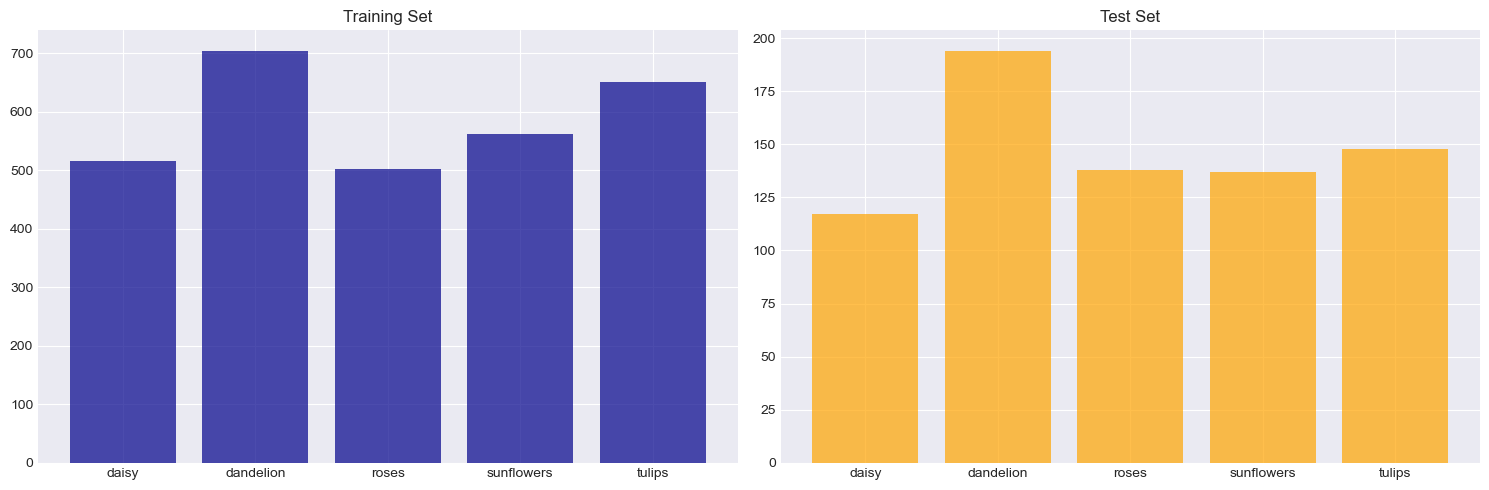

In [ ]:
from utils.helper import fn_plot_label
fn_plot_label(train_ds,test_ds) 

In [10]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

### Data Augmentation

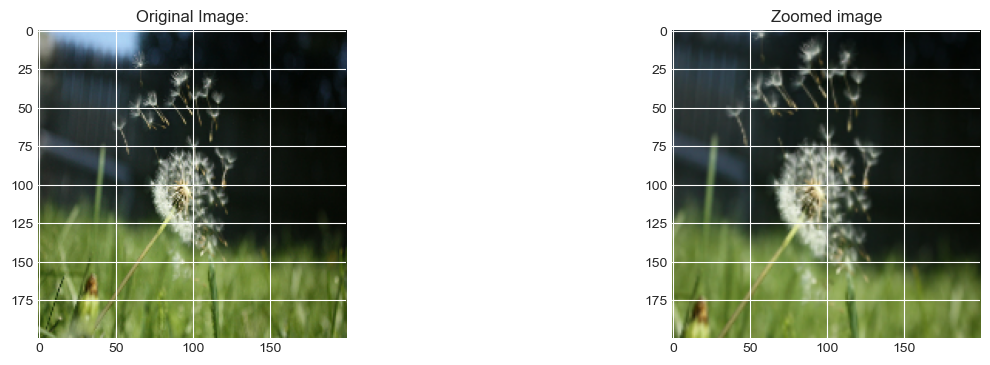

In [ ]:
# zoom layer
layer_zoom = tf.keras.layers.RandomZoom(
    height_factor= (-.2, -.2),
    width_factor=(-.2, -.2),
    fill_value=0.0,
    seed=RANDOM_STATE
)

plt.figure()
img_num = 2
for imgs, lbls in train_ds.take(1):
    out_images = layer_zoom(imgs) # applying the layer on the images in the dataset
    plt.subplot(1,2,1)
    plt.title('Original Image:')
    plt.imshow(imgs[img_num].numpy().astype('uint8'))
    # zoomed image
    plt.subplot(1,2,2)
    plt.title('Zoomed image')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

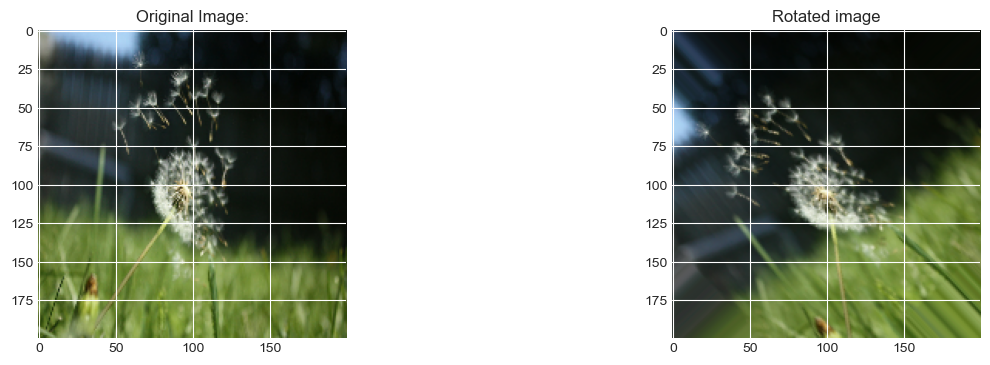

In [ ]:
# rotation of the image
layer_rotate = tf.keras.layers.RandomRotation((-0.2, 0.2), fill_mode='nearest', seed=RANDOM_STATE)
plt.figure()
img_num = 2
for imgs, lbls in train_ds.take(1):
    out_images = layer_rotate(imgs) # applying the layer on the images in the dataset
    plt.subplot(1,2,1)
    plt.title('Original Image:')
    plt.imshow(imgs[img_num].numpy().astype('uint8'))
    # zoomed image
    plt.subplot(1,2,2)
    plt.title('Rotated image')
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

In [14]:
# densenet model
densenet_model = tf.keras.applications.DenseNet169(weights = 'imagenet', include_top=False, input_shape=input_shape)    

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
densenet_model.summary()

Model: "densenet169"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 50, 50,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 50, 50,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 50, 50,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 50, 50,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 50, 50,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 50, 50,    │     12,288 │ conv2_block2_0_r

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 12,484,480 (47.62 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [15]:
for layer in densenet_model.layers:
    print((layer))

<InputLayer name=input_layer, built=True>
<ZeroPadding2D name=zero_padding2d, built=True>
<Conv2D name=conv1_conv, built=True>
<BatchNormalization name=conv1_bn, built=True>
<Activation name=conv1_relu, built=True>
<ZeroPadding2D name=zero_padding2d_1, built=True>
<MaxPooling2D name=pool1, built=True>
<BatchNormalization name=conv2_block1_0_bn, built=True>
<Activation name=conv2_block1_0_relu, built=True>
<Conv2D name=conv2_block1_1_conv, built=True>
<BatchNormalization name=conv2_block1_1_bn, built=True>
<Activation name=conv2_block1_1_relu, built=True>
<Conv2D name=conv2_block1_2_conv, built=True>
<Concatenate name=conv2_block1_concat, built=True>
<BatchNormalization name=conv2_block2_0_bn, built=True>
<Activation name=conv2_block2_0_relu, built=True>
<Conv2D name=conv2_block2_1_conv, built=True>
<BatchNormalization name=conv2_block2_1_bn, built=True>
<Activation name=conv2_block2_1_relu, built=True>
<Conv2D name=conv2_block2_2_conv, built=True>
<Concatenate name=conv2_block2_concat,

In [16]:
num_classes = len(class_names)
num_classes

5

In [19]:
def build_model(d_model, n_classes):
    krnl_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))
    model.add(tf.keras.layers.RandomRotation((-0.2, 0.2), fill_mode='nearest', seed=RANDOM_STATE))
    model.add(tf.keras.layers.Rescaling(1./255.))
    model.add(d_model)  #6x6x1664
    model.add(tf.keras.layers.Flatten())


    model.add(tf.keras.layers.Dense(1664, name='fc_1'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(
    num_classes, 
    name='output'
    ))
    return model


In [21]:
model = build_model(densenet_model, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 6, 6, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,642,880 (48.23 MB)

 Trainable params: 12,484,480 (47.62 MB)

 Non-trainable params: 158,400 (618.75 KB)

In [23]:
# compling the model after defining the adam and loss functions
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
check_file_path = os.path.join(modelDir, subDir, 'dense.weights.h5')

# CHeckpoint 
mbc = tf.keras.callbacks.ModelCheckpoint(
    filepath = check_file_path,
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

# Early Stopping
escb = tf.keras.callbacks.EarlyStopping(
    patience = ES_PATIENCE,
    verbose = 1,
    restore_best_weights = True
)

# Reduce on Plateau
lrcb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = LR_FACTOR,
    patience = LR_PATIENCE,
    verbose = 1
)

In [25]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=test_ds,
    callbacks = [
        mbc,
        escb,
        lrcb
    ],
)


Epoch 1/100
  1/367 ━━━━━━━━━━━━━━━━━━━━ 12:56:56 127s/step - accuracy: 0.3750 - loss: 1.7379

c:\Users\DAI.STUDENTSDC\.conda\envs\pythonProject\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_loss improved from inf to 72.08328, saving model to ../models\flower_photos\dense.weights.h5
367/367 ━━━━━━━━━━━━━━━━━━━━ 193s 180ms/step - accuracy: 0.3750 - loss: 1.7379 - val_accuracy: 0.2643 - val_loss: 72.0833 - learning_rate: 0.0010
Epoch 2/100
  1/367 ━━━━━━━━━━━━━━━━━━━━ 17:03 3s/step - accuracy: 0.6250 - loss: 8.1906
Epoch 2: val_loss did not improve from 72.08328
367/367 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - accuracy: 0.6250 - loss: 8.1906 - val_accuracy: 0.1935 - val_loss: 131.8863 - learning_rate: 0.0010
Epoch 3/100
  1/367 ━━━━━━━━━━━━━━━━━━━━ 12:32 2s/step - accuracy: 0.5000 - loss: 63.8415
Epoch 3: val_loss did not improve from 72.08328
367/367 ━━━━━━━━━━━━━━━━━━━━ 35s 91ms/step - accuracy: 0.5000 - loss: 63.8415 - val_accuracy: 0.2016 - val_loss: 112.0661 - learning_rate: 0.0010
Epoch 4/100
  1/367 ━━━━━━━━━━━━━━━━━━━━ 12:31 2s/step - accuracy: 0.6250 - loss: 18.3117
Epoch 4: val_loss improved from 72.08328 to 68.61797, saving model to ../models\flower_phot

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.304837,2.959296,0.389646,1.327050,0.001
1,0.524864,1.145929,0.523161,1.180341,0.001
2,0.603883,0.953079,0.615804,0.918695,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
10,0.834809,0.438167,0.698910,1.200076,0.001
11,0.867507,0.370469,0.717984,1.338432,0.001
12,0.890668,0.308683,0.720708,1.480786,0.001


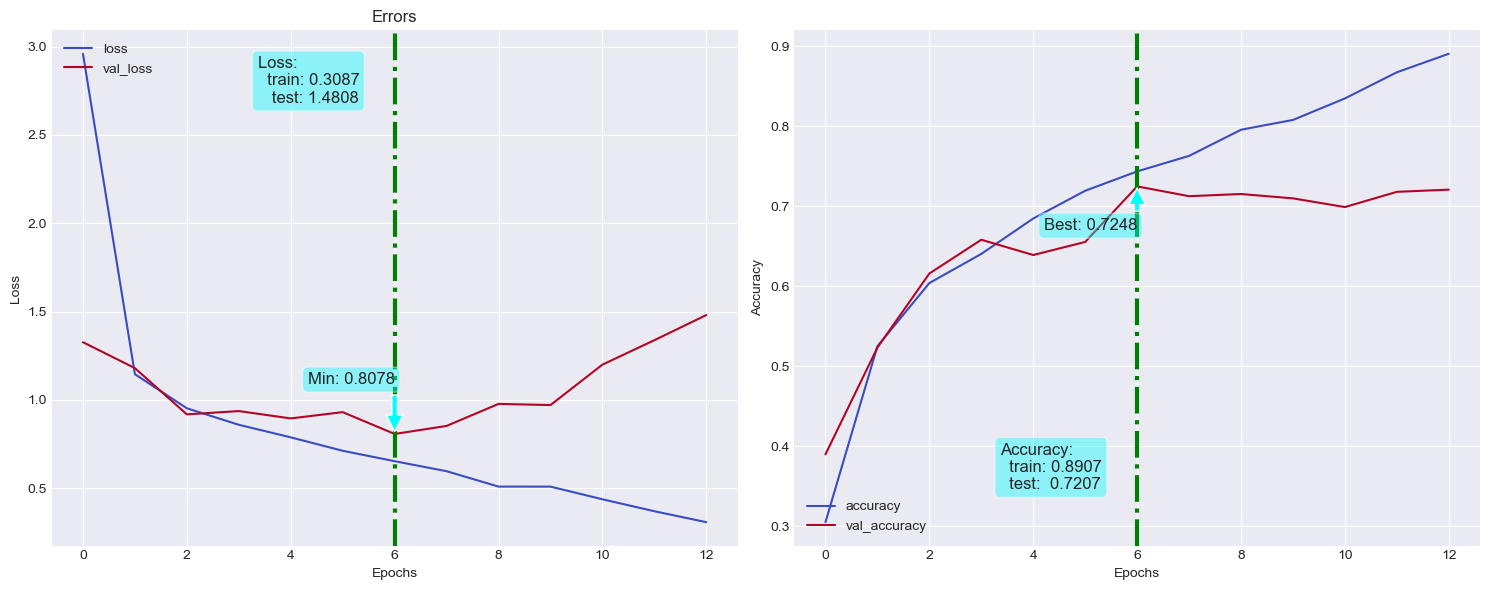

In [29]:
# results and inferences
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)




### Reload best Weights for evaluation

### Evaluate the model

### Validate on the validation set

In [30]:
y_true, y_pred = [], []

for batch_idx, (X, y) in enumerate(test_ds):
    y_true.append(y)
    y_pred.append(model(X))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

y_pred = np.argmax(y_pred, axis=1)


print(f'Accuracy: {accuracy_score(y_true, y_pred):.2f}')

Accuracy: 0.72


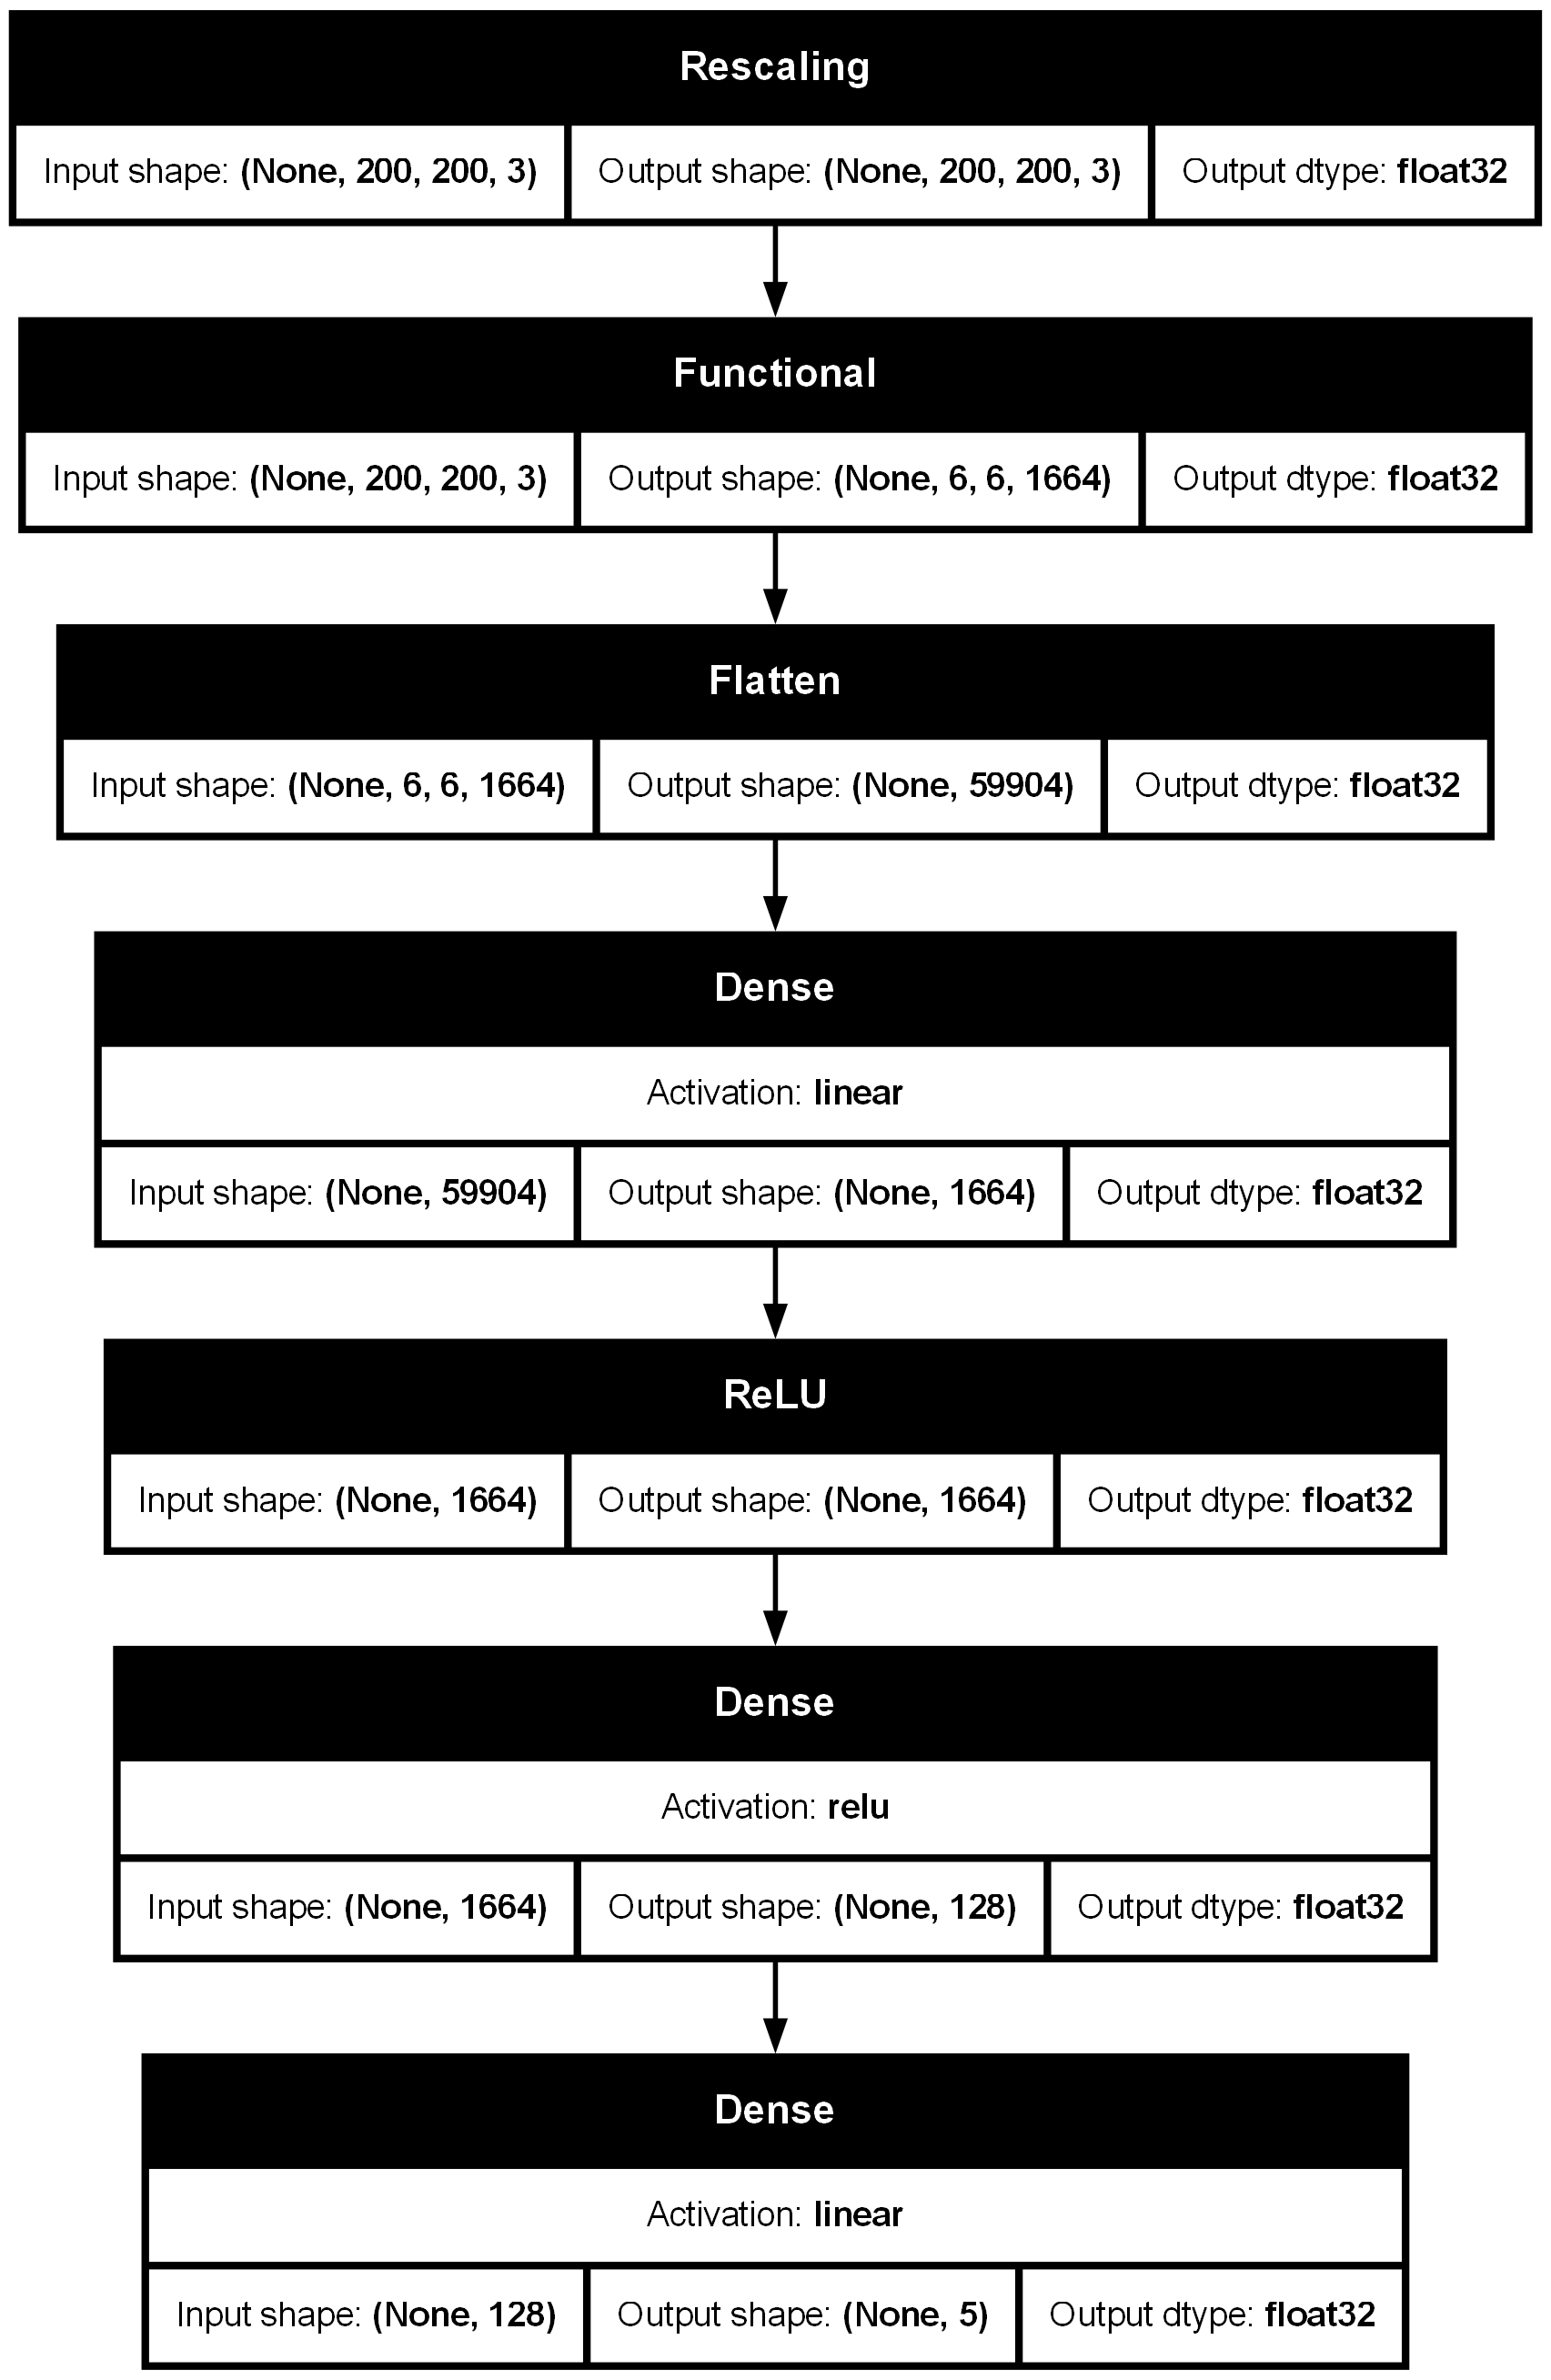

In [26]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'flower_photo.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)